# Multivariate Timeseries Forecasting of Dengue Cases  

# Initial Data Examination and Preliminary Cleaning - Multivariate Focus

## Data Origins and General Description  (repeat from the Univariate Focus notebook)

The data was obtained from Driven Data:  

https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/  

It is comprised of timestamped environmental measurements suspected to have bearing on confirmed dengue cases in two cities:  San Juan, Puerto Rico and Iquitos, Peru.  The labels - number of dengue cases, also timestamped - are also provided for supervised learning approaches.  

The features are as listed:  

##### City and date indicators 
* city – City abbreviations: sj for San Juan and iq for Iquitos  
*  week_start_date – Date given in yyyy-mm-dd format  

##### NOAA's GHCN daily climate data weather station measurements  
* station_max_temp_c – Maximum temperature  
* station_min_temp_c – Minimum temperature  
* station_avg_temp_c – Average temperature  
* station_precip_mm – Total precipitation  
* station_diur_temp_rng_c – Diurnal temperature range  

For further reading:  https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily

##### PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)  
* precipitation_amt_mm – Total precipitation   

##### NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)  
* reanalysis_sat_precip_amt_mm – Total precipitation  
* reanalysis_dew_point_temp_k – Mean dew point temperature  
* reanalysis_air_temp_k – Mean air temperature  
* reanalysis_relative_humidity_percent – Mean relative humidity  
* reanalysis_specific_humidity_g_per_kg – Mean specific humidity  
* reanalysis_precip_amt_kg_per_m2 – Total precipitation  
* reanalysis_max_air_temp_k – Maximum air temperature  
* reanalysis_min_air_temp_k – Minimum air temperature  
* reanalysis_avg_temp_k – Average air temperature  
* reanalysis_tdtr_k – Diurnal temperature range  

For further reading:  https://www.nccs.nasa.gov/services/data-collections/coupled-products/cfsr#:~:text=The%20National%20Oceanic%20and%20Atmospheric,period%20(1979%2D2009).

##### Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements  
* ndvi_se – Pixel southeast of city centroid  
* ndvi_sw – Pixel southwest of city centroid  
* ndvi_ne – Pixel northeast of city centroid  
* ndvi_nw – Pixel northwest of city centroid  

For an explanation of NDVI:  
Wikipedia:  "It has a high correlation with the true state of vegetation on the ground. The index is easy to interpret: NDVI will be a value between -1 and 1. An area with nothing growing in it will have an NDVI of zero. NDVI will increase in proportion to vegetation growth. An area with dense, healthy vegetation will have an NDVI of one. NDVI values less than 0 suggest a lack of dry land. An ocean will yield an NDVI of -1."  
https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index, accessed Feb 2 2024

## Data: Behavioural Characteristics Driving the Analysis

When the timestamped dengue cases are examined on their own, the process is a univariate timeseries forecasting exercise.  This only examines how previous dengue cases impact feature dengue cases to help identify if the output or dependent variable is autocorrelated.  To do this an autoregression (regressing against the same variable) is performed.

When the environmental measurements are included, it becomes a multivariate forecasting exercise.  In these scenarios, not only is autocorrelation of the dependent or predicted variable examined, but its correlation to the features, or time-lagged features, is also examined.  This is to establish whether a causal relationship between the features and predicted variable exists, and over what time lag.  There exists many model frameworks to enable this sort of analysis.

This notebook contains the steps to import the data, examine basic plots of the data and get a general description of its characteristics, then gather more details around the data's temporal characteristics with the use of lag-plots and correlations between the features and the target.  Ultimately, the objective is to gain an idea of the idea lag to use between each feature and the target to set up a model structure that will extract the most useful information to predict dengue cases.

## Import and Overview of Data Quality  

The data are supplied as a set of training features, which is comprised of the environmental measurements, and training labels, which is simply the number of known dengue cases for each corresponding date.  The data is examined for its overall general characteristics like data type, mean, range, and for any anomalies as well as missing or duplicated data.

In [77]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 
#import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import crosscorr
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import concat


In [78]:
# setting up the file path structure
data_folder = os.path.join(os.pardir, 'data')
files_in_data = os.listdir(data_folder)
print(files_in_data)

['dengue_features_test.csv', 'dengue_features_train.csv', 'dengue_labels_train.csv']


This data will not be loaded with any special index as it was for the univariate eda notebook.  We'll need this dataframe to include the date column with the labels, which the files, as provided by Driven Data, do not really contain.  The training features and training labels dataframes will therefore be merged on year and week of the year, keeping the date for the start of the week.  

The data provided by Driven Data for this practice competition does not include the test set's labels, which means model evaluations cannot be completed to satisfaction.  Performance on test data, including the test labels (actual target values) allows the model developer to determine if the models can produce acceptable predictions on unseen data.  

This is addressed by treating the training features and training labels, as named by Driven Data, as though they were an entire un-split dataset.  They will later be split into a training and test set to allow for the model performance metrics to be calculated.  The "dengue_features_test.csv" can be used on a final selected model to create predictions, but there is no "dengue_labels_test.csv" to use.

The variables are named below as though they were not strictly training data.  

In [79]:
# setting index_col sets up a multi-level index
file_path1 = os.path.join(data_folder, 'dengue_features_train.csv')
df_features = pd.read_csv(file_path1)

file_path2 = os.path.join(data_folder, 'dengue_labels_train.csv')
df_labels = pd.read_csv(file_path2)

In [80]:
df_features.shape

(1456, 24)

Interesting note:  using `.head()` as-is will give you the first 5 rows and supply no shape summary at the bottom, similarly for `.tail()` except it's the bottom 5 rows, still no shape summary.  If you enter `.head(-5)`, however, you get the first and last 5 rows *and* a shape summary.  In this case, and for the df_labels dataframe, and the df dataframe (merged result of df_features and df_labels), the shape summary given by `.head(-5)` is 1451 rows.  However, when you call for the `.shape` attribute on each dataframe, you get 1456 rows.  If you change the -5 to -3, now there's a three row difference.  I don't think it's a data integrity concern, but something to be aware of.

In [81]:
df_features.head(-5)

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0      sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1      sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2      sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3      sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4      sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   
...   ...   ...         ...             ...       ...       ...       ...   
1446   iq  2010          16      2010-04-23  0.231486  0.294686  0.331657   
1447   iq  2010          17      2010-04-30  0.239743  0.259271  0.307786   
1448   iq  2010          18      2010-05-07  0.260814  0.255786  0.257771   
1449   iq  2010          19      2010-05-14  0.168686  0.158500  0.133071   
1450   iq  2010          20      2010-05-21  0.263071  0.272500  0.258271   

       ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
0     0.177617                 12.42             297.572857   
1     0.155486                 22.82             298.211429   
2     0.170843                 34.54             298.781429   
3     0.235886                 15.36             298.987143   
4     0.247340                  7.52             299.518571   
...        ...                   ...                    ...   
1446  0.244400                 86.70             298.438571   
1447  0.307943                 26.00             299.048571   
1448  0.340286                 73.97             297.617143   
1449  0.145600                 59.40             297.278571   
1450  0.244500                  1.15             297.648571   

      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
0                297.742857                   292.414286   
1                298.442857                   293.951429   
2                298.878571                   295.434286   
3                299.228571                   295.310000   
4                299.664286                   295.821429   
...                     ...                          ...   
1446             299.507143                   297.678571   
1447             300.028571                   296.468571   
1448             298.585714                   296.975714   
1449             297.935714                   296.738571   
1450             298.707143                   293.227143   

      reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                         299.8                      295.9   
1                         300.9                      296.4   
2                         300.5                      297.3   
3                         301.4                      297.0   
4                         301.9                      297.5   
...                         ...                        ...   
1446                      304.7                      294.7   
1447                      308.4                      294.6   
1448                      304.7                      294.6   
1449                      306.0                      294.0   
1450                      308.7                      290.1   

      reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                               32.00                             73.365714   
1                               17.94                             77.368571   
2                               26.10                             82.052857   
3                               13.90                             80.337143   
4                               12.20                             80.460000   
...                               ...                                   ...   
1446                            81.40                             95.995714   
1447                            23.60                             87.657143   
1448                            85.46                             96.712857   
1449                            87.30                             9

In [82]:
df_features.duplicated().sum()

0

In [83]:
df_features.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [84]:
df_labels.shape

(1456, 4)

In [85]:
df_labels.head(-5)

city  year  weekofyear  total_cases
0      sj  1990          18            4
1      sj  1990          19            5
2      sj  1990          20            4
3      sj  1990          21            3
4      sj  1990          22            6
...   ...   ...         ...          ...
1446   iq  2010          16            8
1447   iq  2010          17            4
1448   iq  2010          18            2
1449   iq  2010          19            7
1450   iq  2010          20            6

[1451 rows x 4 columns]

In [86]:
df_labels.duplicated().sum()

0

In [87]:
df_labels.isnull().sum()

city           0
year           0
weekofyear     0
total_cases    0
dtype: int64

Merge the dataframes on city, year, and weekofyear.

In [88]:
pd.set_option('display.max_columns', None)
df = pd.merge(df_features, df_labels, on=['city', 'year', 'weekofyear'])
df.head(-5)

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0      sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1      sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2      sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3      sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4      sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   
...   ...   ...         ...             ...       ...       ...       ...   
1446   iq  2010          16      2010-04-23  0.231486  0.294686  0.331657   
1447   iq  2010          17      2010-04-30  0.239743  0.259271  0.307786   
1448   iq  2010          18      2010-05-07  0.260814  0.255786  0.257771   
1449   iq  2010          19      2010-05-14  0.168686  0.158500  0.133071   
1450   iq  2010          20      2010-05-21  0.263071  0.272500  0.258271   

       ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
0     0.177617                 12.42             297.572857   
1     0.155486                 22.82             298.211429   
2     0.170843                 34.54             298.781429   
3     0.235886                 15.36             298.987143   
4     0.247340                  7.52             299.518571   
...        ...                   ...                    ...   
1446  0.244400                 86.70             298.438571   
1447  0.307943                 26.00             299.048571   
1448  0.340286                 73.97             297.617143   
1449  0.145600                 59.40             297.278571   
1450  0.244500                  1.15             297.648571   

      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
0                297.742857                   292.414286   
1                298.442857                   293.951429   
2                298.878571                   295.434286   
3                299.228571                   295.310000   
4                299.664286                   295.821429   
...                     ...                          ...   
1446             299.507143                   297.678571   
1447             300.028571                   296.468571   
1448             298.585714                   296.975714   
1449             297.935714                   296.738571   
1450             298.707143                   293.227143   

      reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                         299.8                      295.9   
1                         300.9                      296.4   
2                         300.5                      297.3   
3                         301.4                      297.0   
4                         301.9                      297.5   
...                         ...                        ...   
1446                      304.7                      294.7   
1447                      308.4                      294.6   
1448                      304.7                      294.6   
1449                      306.0                      294.0   
1450                      308.7                      290.1   

      reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                               32.00                             73.365714   
1                               17.94                             77.368571   
2                               26.10                             82.052857   
3                               13.90                             80.337143   
4                               12.20                             80.460000   
...                               ...                                   ...   
1446                            81.40                             95.995714   
1447                            23.60                             87.657143   
1448                            85.46                             96.712857   
1449                            87.30                             9

The two datasets, features and labels, are now merged on the common columns.  Every row of data, be it feature or label (target value) data now has a date column associated with it.  The row count is as expected (1451) and the columns total to 25, which reflects the total number of columns after the merge.  

In [89]:
df.shape

(1456, 25)

In [90]:
df.duplicated().sum()

0

In [91]:
df.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi


Let's view some quick statistics before things get more involved.

In [92]:
df.describe()

year   weekofyear      ndvi_ne      ndvi_nw      ndvi_se  \
count  1456.000000  1456.000000  1262.000000  1404.000000  1434.000000   
mean   2001.031593    26.503434     0.142294     0.130553     0.203783   
std       5.408314    15.019437     0.140531     0.119999     0.073860   
min    1990.000000     1.000000    -0.406250    -0.456100    -0.015533   
25%    1997.000000    13.750000     0.044950     0.049217     0.155087   
50%    2002.000000    26.500000     0.128817     0.121429     0.196050   
75%    2005.000000    39.250000     0.248483     0.216600     0.248846   
max    2010.000000    53.000000     0.508357     0.454429     0.538314   

           ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
count  1434.000000           1443.000000            1446.000000   
mean      0.202305             45.760388             298.701852   
std       0.083903             43.715537               1.362420   
min      -0.063457              0.000000             294.635714   
25%       0.144209              9.800000             297.658929   
50%       0.189450             38.340000             298.646429   
75%       0.246982             70.235000             299.833571   
max       0.546017            390.600000             302.200000   

       reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
count            1446.000000                  1446.000000   
mean              299.225578                   295.246356   
std                 1.261715                     1.527810   
min               294.892857                   289.642857   
25%               298.257143                   294.118929   
50%               299.289286                   295.640714   
75%               300.207143                   296.460000   
max               302.928571                   298.450000   

       reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
count                1446.000000                1446.000000   
mean                  303.427109                 295.719156   
std                     3.234601                   2.565364   
min                   297.800000                 286.900000   
25%                   301.000000                 293.900000   
50%                   302.400000                 296.200000   
75%                   305.500000                 297.900000   
max                   314.000000                 299.900000   

       reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
count                      1446.000000                           1446.000000   
mean                         40.151819                             82.161959   
std                          43.434399                              7.153897   
min                           0.000000                             57.787143   
25%                          13.055000                             77.177143   
50%                          27.245000                             80.301429   
75%                          52.200000                             86.357857   
max                         570.500000                             98.610000   

       reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
count                   1443.000000                            1446.000000   
mean                      45.760388                              16.746427   
std                       43.715537                               1.542494   
min                        0.000000                              11.715714   
25%                        9.800000                              15.557143   
50%                       38.340000                              17.087143   
75%                       70.235000                              17.978214   
max                      390.600000                              20.461429   

       reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
count        1446.000000         1413.000000              1413.000000   
mean            4.903754           27.185783           

Brief overview:
* We can see the dataset runs from 1990 to 2010
* Variable ranges vary from the very small (ndvi values) to larger (precipitation amounts)
* There may be missing data, as the count row changes.  This was seen in the `.isnull()` results.  
a) note:  the counts discrepancy between the `.head(-5)` summary and the `.shape` values returned would suggest there's a 5 row discrepancy.  I currently have no explanation for this).

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

We see most variables are floats, while the target is an integer, as are the year and weekofyear.  The week_start_date is object datatype, so it remains to be seen if it needs to be cast to datetime for the modelling algorithms that will later be used.  City is naturallyl object datatype.

The time interval between rows was already verified to be one week in the univaritate eda notebook, with reasonable constancy.  Only a few rows went to 8 days, rather than 7, and even fewer went to 9.  The big jump in interval occurs when the dataframe reaches the end of the first city's rows and then changes to the next city's rows.  

We saw above there are no duplicates, but there are nulls.  Let's have a look at an overview of where the nulls are situated.

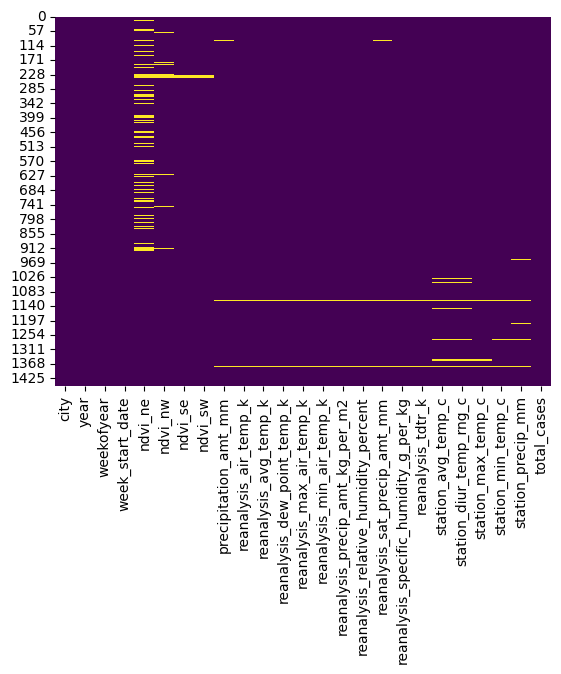

In [94]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

There are a few rows where there's a large amount of nulls past the 1000 row mark.  Some features, like ndvi_ne seem to have a high number of nulls.  

The investigation below reveals San Juan is in the first 936 rows, while Iquitos is in rows 936 onward.  It would appear San Juan is more impacted by the nulls in feature ndvi_ne.  Iquitos is more impacted by the nearly all-null rows in the latter half of the dataset.

In [95]:
df[df['city']=='sj']

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0     sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1     sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2     sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3     sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4     sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   
..   ...   ...         ...             ...       ...       ...       ...   
931   sj  2008          13      2008-03-25  0.077850 -0.039900  0.310471   
932   sj  2008          14      2008-04-01 -0.038000 -0.016833  0.119371   
933   sj  2008          15      2008-04-08 -0.155200 -0.052750  0.137757   
934   sj  2008          16      2008-04-15  0.001800       NaN  0.203900   
935   sj  2008          17      2008-04-22 -0.037000 -0.010367  0.077314   

      ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
0    0.177617                 12.42             297.572857   
1    0.155486                 22.82             298.211429   
2    0.170843                 34.54             298.781429   
3    0.235886                 15.36             298.987143   
4    0.247340                  7.52             299.518571   
..        ...                   ...                    ...   
931  0.296243                 27.19             296.958571   
932  0.066386                  3.82             298.081429   
933  0.141214                 16.96             297.460000   
934  0.209843                  0.00             297.630000   
935  0.090586                  0.00             298.672857   

     reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
0               297.742857                   292.414286   
1               298.442857                   293.951429   
2               298.878571                   295.434286   
3               299.228571                   295.310000   
4               299.664286                   295.821429   
..                     ...                          ...   
931             296.957143                   292.095714   
932             298.228571                   293.235714   
933             297.564286                   292.732857   
934             297.778571                   292.274286   
935             298.692857                   294.280000   

     reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
0                        299.8                      295.9   
1                        300.9                      296.4   
2                        300.5                      297.3   
3                        301.4                      297.0   
4                        301.9                      297.5   
..                         ...                        ...   
931                      299.7                      294.4   
932                      299.8                      296.5   
933                      299.4                      295.8   
934                      299.7                      295.9   
935                      300.9                      295.9   

     reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                              32.00                             73.365714   
1                              17.94                             77.368571   
2                              26.10                             82.052857   
3                              13.90                             80.337143   
4                              12.20                             80.460000   
..                               ...                                   ...   
931                             7.55                             74.247143   
932                             3.67                             74.600000   
933                            35.00                             75.027143   
934                             4.82                             72.285714   
935                             2.17          

In [96]:
(df[df['city']=='sj']).shape

(936, 25)

In [97]:
df[df['city']=='iq']

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
936    iq  2000          26      2000-07-01  0.192886  0.132257  0.340886   
937    iq  2000          27      2000-07-08  0.216833  0.276100  0.289457   
938    iq  2000          28      2000-07-15  0.176757  0.173129  0.204114   
939    iq  2000          29      2000-07-22  0.227729  0.145429  0.254200   
940    iq  2000          30      2000-07-29  0.328643  0.322129  0.254371   
...   ...   ...         ...             ...       ...       ...       ...   
1451   iq  2010          21      2010-05-28  0.342750  0.318900  0.256343   
1452   iq  2010          22      2010-06-04  0.160157  0.160371  0.136043   
1453   iq  2010          23      2010-06-11  0.247057  0.146057  0.250357   
1454   iq  2010          24      2010-06-18  0.333914  0.245771  0.278886   
1455   iq  2010          25      2010-06-25  0.298186  0.232971  0.274214   

       ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
936   0.247200                 25.41             296.740000   
937   0.241657                 60.61             296.634286   
938   0.128014                 55.52             296.415714   
939   0.200314                  5.60             295.357143   
940   0.361043                 62.76             296.432857   
...        ...                   ...                    ...   
1451  0.292514                 55.30             299.334286   
1452  0.225657                 86.47             298.330000   
1453  0.233714                 58.94             296.598571   
1454  0.325486                 59.67             296.345714   
1455  0.315757                 63.22             298.097143   

      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
936              298.450000                   295.184286   
937              298.428571                   295.358571   
938              297.392857                   295.622857   
939              296.228571                   292.797143   
940              297.635714                   293.957143   
...                     ...                          ...   
1451             300.771429                   296.825714   
1452             299.392857                   296.452857   
1453             297.592857                   295.501429   
1454             297.521429                   295.324286   
1455             299.835714                   295.807143   

      reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
936                       307.3                      293.1   
937                       306.6                      291.1   
938                       304.5                      292.6   
939                       303.6                      288.6   
940                       307.0                      291.5   
...                         ...                        ...   
1451                      309.7                      294.5   
1452                      308.5                      291.9   
1453                      305.5                      292.4   
1454                      306.1                      291.9   
1455                      307.8                      292.3   

      reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
936                             43.19                             92.418571   
937                             46.00                             93.581429   
938                             64.77                             95.848571   
939                             23.96                             87.234286   
940                             31.80                             88.161429   
...                               ...                                   ...   
1451                            45.00                             88.765714   
1452                           207.10                             91.600000   
1453                            50.60                             94.280000   
1454                            62.33                             9

In [98]:
(df[df['city']=='iq']).shape

(520, 25)

### Imputation  

Null values for now will be very simply imputed using forward fill, which simply takes the last known value and enters it into the null locations for a given column.  This may be revisited for more sophisticated methods.

In [99]:
df.fillna(method='ffill', inplace=True)

C:\Users\ron_d\AppData\Local\Temp\ipykernel_5256\3970806690.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


### Pseudo-Redundant Features  

Work was done in the univariate notebook to try to identify why there are seemingly duplicate environmental measurements of temperature and precipitation.  At this time it is not clear why both were included or how they're collected and processed.  For the sake of this first-pass analysis, the same pseudo-redundant features will be dropped in order to keep the number of visual inspections of plots, and the number of correlations (including lagged correlations) to a manageable number.  This can be revisited after some modelling work as is consistent with the iterative nature of this work.

In [100]:
df.shape

(1456, 25)

In [101]:
pseudo_redundant_features = (['station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c', 'precipitation_amt_mm',
                              'station_precip_mm', 'station_diur_temp_rng_c'])

for r_feature in pseudo_redundant_features:
    df.drop(r_feature, axis=1, inplace=True)

In [102]:
df.shape

(1456, 19)

In [103]:
df.head(-5)

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0      sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1      sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2      sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3      sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4      sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   
...   ...   ...         ...             ...       ...       ...       ...   
1446   iq  2010          16      2010-04-23  0.231486  0.294686  0.331657   
1447   iq  2010          17      2010-04-30  0.239743  0.259271  0.307786   
1448   iq  2010          18      2010-05-07  0.260814  0.255786  0.257771   
1449   iq  2010          19      2010-05-14  0.168686  0.158500  0.133071   
1450   iq  2010          20      2010-05-21  0.263071  0.272500  0.258271   

       ndvi_sw  reanalysis_air_temp_k  reanalysis_avg_temp_k  \
0     0.177617             297.572857             297.742857   
1     0.155486             298.211429             298.442857   
2     0.170843             298.781429             298.878571   
3     0.235886             298.987143             299.228571   
4     0.247340             299.518571             299.664286   
...        ...                    ...                    ...   
1446  0.244400             298.438571             299.507143   
1447  0.307943             299.048571             300.028571   
1448  0.340286             297.617143             298.585714   
1449  0.145600             297.278571             297.935714   
1450  0.244500             297.648571             298.707143   

      reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
0                      292.414286                      299.8   
1                      293.951429                      300.9   
2                      295.434286                      300.5   
3                      295.310000                      301.4   
4                      295.821429                      301.9   
...                           ...                        ...   
1446                   297.678571                      304.7   
1447                   296.468571                      308.4   
1448                   296.975714                      304.7   
1449                   296.738571                      306.0   
1450                   293.227143                      308.7   

      reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
0                         295.9                            32.00   
1                         296.4                            17.94   
2                         297.3                            26.10   
3                         297.0                            13.90   
4                         297.5                            12.20   
...                         ...                              ...   
1446                      294.7                            81.40   
1447                      294.6                            23.60   
1448                      294.6                            85.46   
1449                      294.0                            87.30   
1450                      290.1                             8.80   

      reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
0                                73.365714                         12.42   
1                                77.368571                         22.82   
2                                82.052857                         34.54   
3                                80.337143                         15.36   
4                                80.460000                          7.52   
...                                    ...                           ...   
1446                             95.995714                         86.70   
1447                             87.657143                         26.00   
1448                             96.71285

Another look at the statistics may be warranted given the imputation done above.  

# !
Maybe assign these results, and the one above, to a variable of a different name so they can be put "side by side" (directly above and below) for easy comparison.  Right now it's hard to scroll up & down to compare.  Maybe it's exportable, but putting them both on screen here would be nice.

In [104]:
df.describe()

year   weekofyear      ndvi_ne      ndvi_nw      ndvi_se  \
count  1456.000000  1456.000000  1456.000000  1456.000000  1456.000000   
mean   2001.031593    26.503434     0.131271     0.128068     0.202606   
std       5.408314    15.019437     0.138527     0.119561     0.074409   
min    1990.000000     1.000000    -0.406250    -0.456100    -0.015533   
25%    1997.000000    13.750000     0.039100     0.048250     0.152795   
50%    2002.000000    26.500000     0.113900     0.115926     0.195664   
75%    2005.000000    39.250000     0.232018     0.213429     0.247461   
max    2010.000000    53.000000     0.508357     0.454429     0.538314   

           ndvi_sw  reanalysis_air_temp_k  reanalysis_avg_temp_k  \
count  1456.000000            1456.000000            1456.000000   
mean      0.201987             298.697965             299.221483   
std       0.083592               1.361950               1.262676   
min      -0.063457             294.635714             294.892857   
25%       0.144455             297.654643             298.257143   
50%       0.190121             298.646429             299.285714   
75%       0.246775             299.827500             300.207143   
max       0.546017             302.200000             302.928571   

       reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
count                  1456.000000                1456.000000   
mean                    295.245445                 303.419505   
std                       1.527527                   3.233030   
min                     289.642857                 297.800000   
25%                     294.119643                 301.000000   
50%                     295.639286                 302.400000   
75%                     296.460000                 305.500000   
max                     298.450000                 314.000000   

       reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
count                1456.000000                      1456.000000   
mean                  295.719712                        40.111635   
std                     2.559398                        43.329174   
min                   286.900000                         0.000000   
25%                   293.900000                        13.085000   
50%                   296.200000                        27.245000   
75%                   297.900000                        52.200000   
max                   299.900000                       570.500000   

       reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
count                           1456.000000                   1456.000000   
mean                              82.176203                     45.686937   
std                                7.161016                     43.779318   
min                               57.787143                      0.000000   
25%                               77.185714                      9.655000   
50%                               80.301429                     38.235000   
75%                               86.406429                     70.227500   
max                               98.610000                    390.600000   

       reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  total_cases  
count                            1456.000000        1456.000000  1456.000000  
mean                               16.745565           4.898656    24.675137  
std                                 1.542276           3.542340    43.596000  
min                                11.715714           1.357143     0.000000  
25%                                15.560000           2.328571     5.000000  
50%                                17.087143           2.857143    12.000000  
75%                                17.977500           7.617857    28.000000  
max                                20.461429          16.028571   461.000000

### Separate the Data by City  

In [105]:
sj_df = df[df['city'] == 'sj']
iq_df = df[df['city'] == 'iq']

# Reset the index to have a proper order
sj_df.reset_index(drop=True, inplace=True)
iq_df.reset_index(drop=True, inplace=True)

The below checks that this worked as expected.  The shape returned matches what was found in the null check above.  We can proceed.

In [106]:
sj_df.shape

(936, 19)

In [107]:
sj_df.head(-1)

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0     sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1     sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2     sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3     sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4     sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   
..   ...   ...         ...             ...       ...       ...       ...   
930   sj  2008          12      2008-03-18  0.044900  0.024450  0.101629   
931   sj  2008          13      2008-03-25  0.077850 -0.039900  0.310471   
932   sj  2008          14      2008-04-01 -0.038000 -0.016833  0.119371   
933   sj  2008          15      2008-04-08 -0.155200 -0.052750  0.137757   
934   sj  2008          16      2008-04-15  0.001800 -0.052750  0.203900   

      ndvi_sw  reanalysis_air_temp_k  reanalysis_avg_temp_k  \
0    0.177617             297.572857             297.742857   
1    0.155486             298.211429             298.442857   
2    0.170843             298.781429             298.878571   
3    0.235886             298.987143             299.228571   
4    0.247340             299.518571             299.664286   
..        ...                    ...                    ...   
930  0.088000             297.404286             297.435714   
931  0.296243             296.958571             296.957143   
932  0.066386             298.081429             298.228571   
933  0.141214             297.460000             297.564286   
934  0.209843             297.630000             297.778571   

     reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
0                     292.414286                      299.8   
1                     293.951429                      300.9   
2                     295.434286                      300.5   
3                     295.310000                      301.4   
4                     295.821429                      301.9   
..                           ...                        ...   
930                   292.205714                      299.8   
931                   292.095714                      299.7   
932                   293.235714                      299.8   
933                   292.732857                      299.4   
934                   292.274286                      299.7   

     reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
0                        295.9                            32.00   
1                        296.4                            17.94   
2                        297.3                            26.10   
3                        297.0                            13.90   
4                        297.5                            12.20   
..                         ...                              ...   
930                      294.9                             0.90   
931                      294.4                             7.55   
932                      296.5                             3.67   
933                      295.8                            35.00   
934                      295.9                             4.82   

     reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
0                               73.365714                         12.42   
1                               77.368571                         22.82   
2                               82.052857                         34.54   
3                               80.337143                         15.36   
4                               80.460000                          7.52   
..                                    ...                           ...   
930                             72.915714                          0.00   
931                             74.247143                         27.19   
932                             74.600000                          3.82   
933                   

In [108]:
iq_df.shape

(520, 19)

In [109]:
iq_df.head(-1)

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0     iq  2000          26      2000-07-01  0.192886  0.132257  0.340886   
1     iq  2000          27      2000-07-08  0.216833  0.276100  0.289457   
2     iq  2000          28      2000-07-15  0.176757  0.173129  0.204114   
3     iq  2000          29      2000-07-22  0.227729  0.145429  0.254200   
4     iq  2000          30      2000-07-29  0.328643  0.322129  0.254371   
..   ...   ...         ...             ...       ...       ...       ...   
514   iq  2010          20      2010-05-21  0.263071  0.272500  0.258271   
515   iq  2010          21      2010-05-28  0.342750  0.318900  0.256343   
516   iq  2010          22      2010-06-04  0.160157  0.160371  0.136043   
517   iq  2010          23      2010-06-11  0.247057  0.146057  0.250357   
518   iq  2010          24      2010-06-18  0.333914  0.245771  0.278886   

      ndvi_sw  reanalysis_air_temp_k  reanalysis_avg_temp_k  \
0    0.247200             296.740000             298.450000   
1    0.241657             296.634286             298.428571   
2    0.128014             296.415714             297.392857   
3    0.200314             295.357143             296.228571   
4    0.361043             296.432857             297.635714   
..        ...                    ...                    ...   
514  0.244500             297.648571             298.707143   
515  0.292514             299.334286             300.771429   
516  0.225657             298.330000             299.392857   
517  0.233714             296.598571             297.592857   
518  0.325486             296.345714             297.521429   

     reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
0                     295.184286                      307.3   
1                     295.358571                      306.6   
2                     295.622857                      304.5   
3                     292.797143                      303.6   
4                     293.957143                      307.0   
..                           ...                        ...   
514                   293.227143                      308.7   
515                   296.825714                      309.7   
516                   296.452857                      308.5   
517                   295.501429                      305.5   
518                   295.324286                      306.1   

     reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
0                        293.1                            43.19   
1                        291.1                            46.00   
2                        292.6                            64.77   
3                        288.6                            23.96   
4                        291.5                            31.80   
..                         ...                              ...   
514                      290.1                             8.80   
515                      294.5                            45.00   
516                      291.9                           207.10   
517                      292.4                            50.60   
518                      291.9                            62.33   

     reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
0                               92.418571                         25.41   
1                               93.581429                         60.61   
2                               95.848571                         55.52   
3                               87.234286                          5.60   
4                               88.161429                         62.76   
..                                    ...                           ...   
514                             78.998571                          1.15   
515                             88.765714                         55.30   
516                             91.600000                         86.47   
517                   

## Data Distribution - Multivariate Exploration  

### Histograms and Timeseries Plots  

The below repeats some of what was done in the univariate notebook.  Time permitting, this will be cleaned up in the univariate notebook as it is not strictly required there to prepare for autoregression models.  

One note:  I will be splitting the data into training and tests sets before carrying out stationarity and correlation tests.  An argument could be made for doing the EDA below also after training and test sets have been created, but I'm not certain at this time that my visual inspection will reveal profound insights to nudge my approach one way or another.  This can be revisited after some research on best practices.  

Let's first identify the feature columns for easier plotting.

In [110]:
df.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'total_cases'],
      dtype='object')

In [111]:
features = df.columns[4:18]
features

Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k'],
      dtype='object')

Now we can produce histograms and timeseries of the features for San Juan and Iquitos.

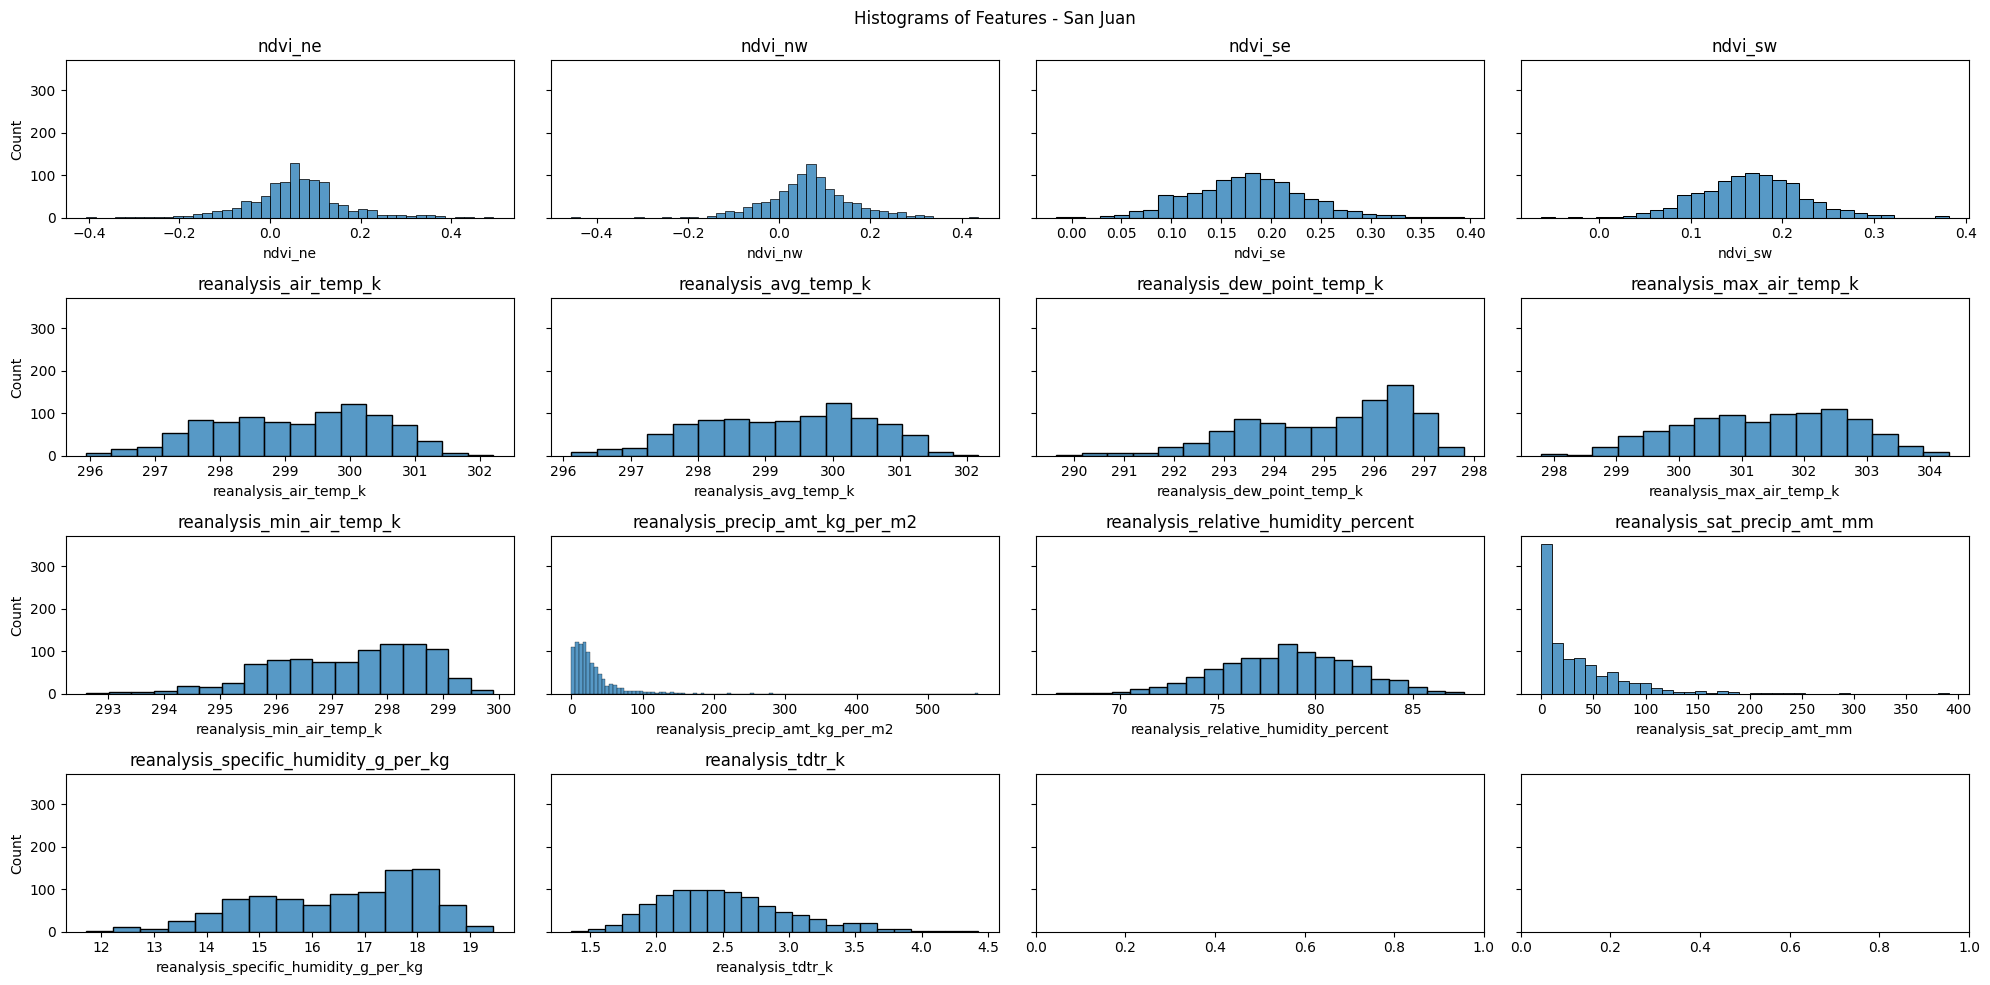

In [112]:
# Feature histograms for San Juan (sj)

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 10), sharey=True)
fig.suptitle('Histograms of Features - San Juan')

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Loop through the features and create boxplots on each subplot
for i, feature in enumerate(features):
    sns.histplot(x=sj_df[feature], ax=axes[i])
    axes[i].set_title(feature)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

The features above for San Juan show ndvi plots that resemble Gaussian distributions.  All other features do not exhibit Gaussian characteristics.  The precipitation amounts in particular have skewed distributions.

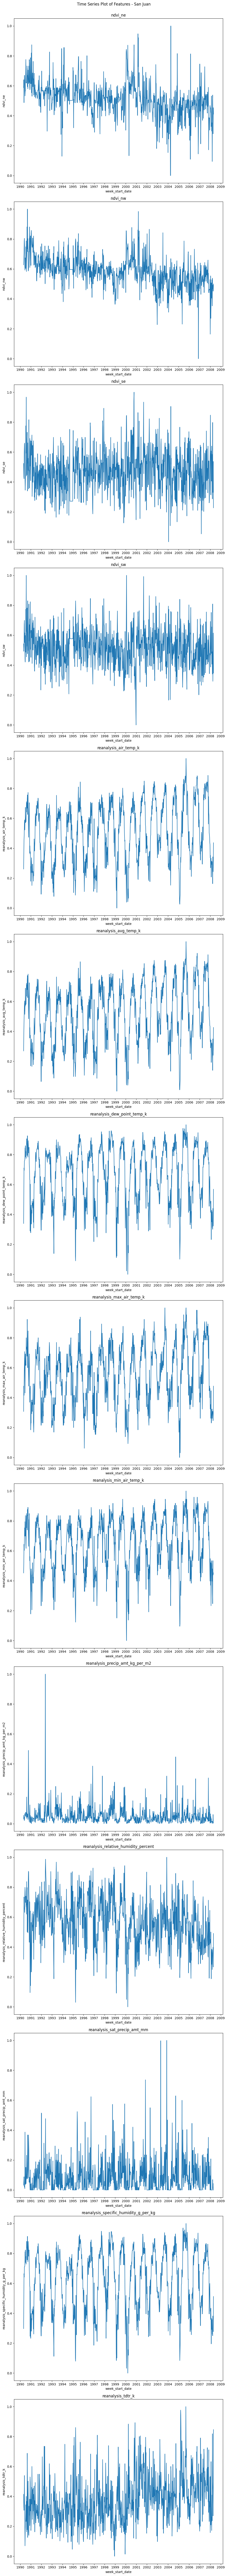

In [113]:
# Calculate the number of rows and columns needed based on the number of features
num_features = len(features)
num_rows = num_features
num_cols = 1

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8 * num_rows), sharey=True)
fig.suptitle('Time Series Plot of Features - San Juan', y=1.00)  # Adjust the y position

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
sj_df_normalized = sj_df.copy()
sj_df_normalized[features] = scaler.fit_transform(sj_df[features])

# Convert 'week_start_date' to datetime format
sj_df_normalized['week_start_date'] = pd.to_datetime(sj_df_normalized['week_start_date'])

# Loop through the features and create line plots on each subplot
for i, feature in enumerate(features):
    sns.lineplot(x='week_start_date', y=feature, data=sj_df_normalized, ax=axes[i])
    axes[i].set_title(feature)

# Set the x-axis locator to show only years
for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Show every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

The ndvi features show some slight trending behaviour (general shift upwards or downwards), as does the diurnal temperature range.  The air temperatures, dew point, relative and specific humidity all exhibit seasonality (oscillations of roughly a known frequency).  Precipitation also presents seasonal behaviour.

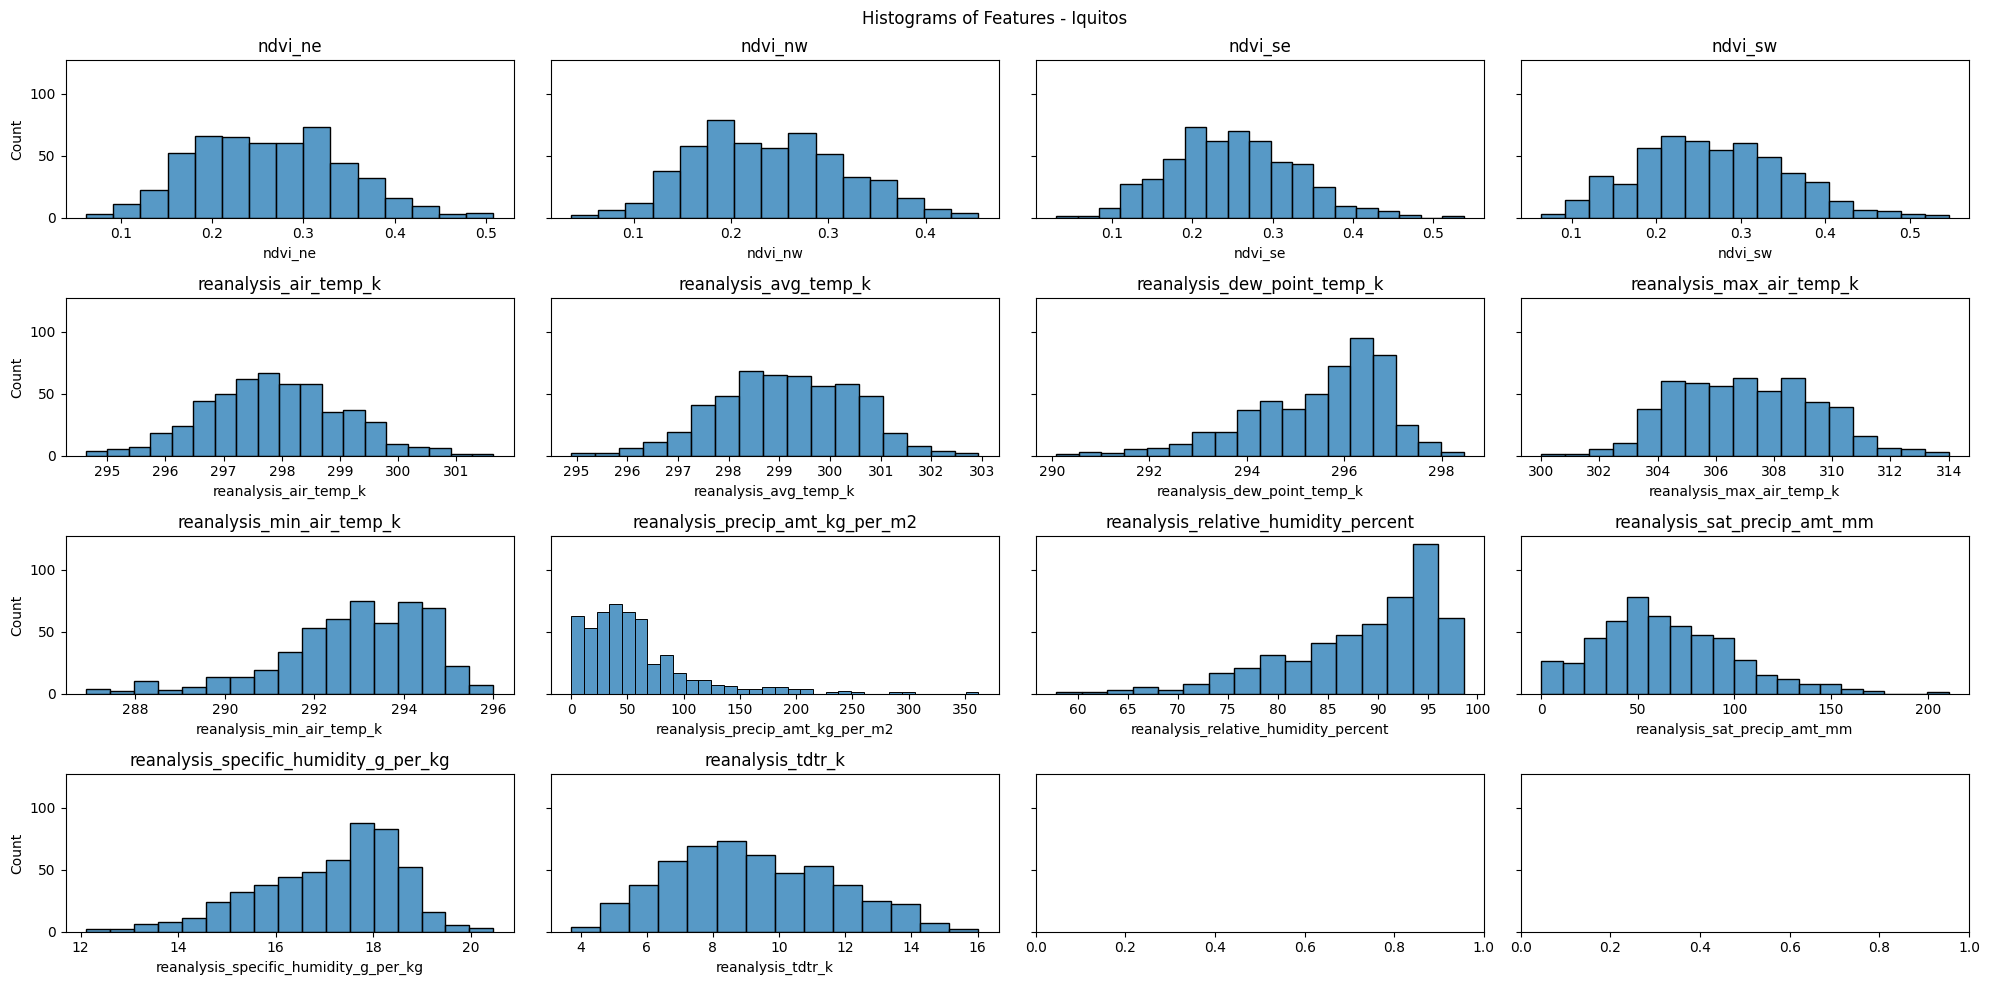

In [114]:
# Feature histograms for Iquitos (iq)

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 10), sharey=True)
fig.suptitle('Histograms of Features - Iquitos')

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Loop through the features and create boxplots on each subplot
for i, feature in enumerate(features):
    sns.histplot(x=iq_df[feature], ax=axes[i])
    axes[i].set_title(feature)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

Iquitos' ndvi features, air temperature, average temperature, and maximum temperature all have somewhat Gaussian distributions.  All other features are generally skewed to one side or the other.

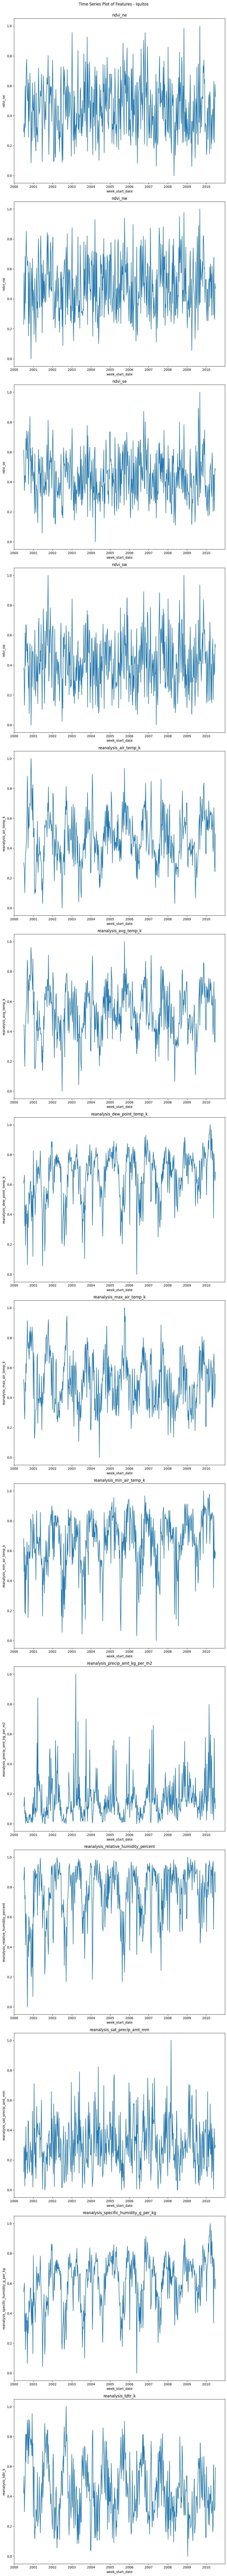

In [115]:
# Calculate the number of rows and columns needed based on the number of features
num_features = len(features)
num_rows = num_features
num_cols = 1

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8 * num_rows), sharey=True)
fig.suptitle('Time Series Plot of Features - Iquitos', y=1.00)  # Adjust the y position

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
iq_df_normalized = iq_df.copy()
iq_df_normalized[features] = scaler.fit_transform(iq_df[features])

# Convert 'week_start_date' to datetime format
iq_df_normalized['week_start_date'] = pd.to_datetime(iq_df_normalized['week_start_date'])

# Loop through the features and create line plots on each subplot
for i, feature in enumerate(features):
    sns.lineplot(x='week_start_date', y=feature, data=iq_df_normalized, ax=axes[i])
    axes[i].set_title(feature)

# Set the x-axis locator to show only years
for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Show every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

Note that data for San Juan start in 1990 while Iquitos starts in 2000.  

Iquitos' ndvi features don't seem to exhibit trending behaviour as San Juan's seemed to.  All other features do show some seasonality.

## Prepare Data for Post-Split Metrics, Tests, and Modelling  

### Casting to DateTime  
The week_start_date column will be cast from object to datetime before timeseries modelling efforts begin later.  

In [116]:
sj_df['week_start_date'].dtype

dtype('O')

In [117]:
#sj_df['weekstartdate_dt'] = pd.to_datetime(sj_df['week_start_date'])
#iq_df['weekstartdate_dt'] = pd.to_datetime(iq_df['week_start_date'])

In [118]:
#sj_df['weekstartdate_dt'] = pd.to_datetime(sj_df['week_start_date'].copy())
#iq_df['weekstartdate_dt'] = pd.to_datetime(iq_df['week_start_date'].copy())

In [119]:
sj_df.loc[:, 'weekstartdate_dt'] = pd.to_datetime(sj_df['week_start_date'])
iq_df.loc[:, 'weekstartdate_dt'] = pd.to_datetime(iq_df['week_start_date'])

C:\Users\ron_d\AppData\Local\Temp\ipykernel_5256\4100593637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sj_df.loc[:, 'weekstartdate_dt'] = pd.to_datetime(sj_df['week_start_date'])
C:\Users\ron_d\AppData\Local\Temp\ipykernel_5256\4100593637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iq_df.loc[:, 'weekstartdate_dt'] = pd.to_datetime(iq_df['week_start_date'])


In [120]:
sj_df.head()

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3   sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4   sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   

    ndvi_sw  reanalysis_air_temp_k  reanalysis_avg_temp_k  \
0  0.177617             297.572857             297.742857   
1  0.155486             298.211429             298.442857   
2  0.170843             298.781429             298.878571   
3  0.235886             298.987143             299.228571   
4  0.247340             299.518571             299.664286   

   reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
0                   292.414286                      299.8   
1                   293.951429                      300.9   
2                   295.434286                      300.5   
3                   295.310000                      301.4   
4                   295.821429                      301.9   

   reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
0                      295.9                            32.00   
1                      296.4                            17.94   
2                      297.3                            26.10   
3                      297.0                            13.90   
4                      297.5                            12.20   

   reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
0                             73.365714                         12.42   
1                             77.368571                         22.82   
2                             82.052857                         34.54   
3                             80.337143                         15.36   
4                             80.460000                          7.52   

   reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  total_cases  \
0                              14.012857           2.628571            4   
1                              15.372857           2.371429            5   
2                              16.848571           2.300000            4   
3                              16.672857           2.428571            3   
4                              17.210000           3.014286            6   

  weekstartdate_dt  
0       1990-04-30  
1       1990-05-07  
2       1990-05-14  
3       1990-05-21  
4       1990-05-28

In [121]:
iq_df.head()

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0   iq  2000          26      2000-07-01  0.192886  0.132257  0.340886   
1   iq  2000          27      2000-07-08  0.216833  0.276100  0.289457   
2   iq  2000          28      2000-07-15  0.176757  0.173129  0.204114   
3   iq  2000          29      2000-07-22  0.227729  0.145429  0.254200   
4   iq  2000          30      2000-07-29  0.328643  0.322129  0.254371   

    ndvi_sw  reanalysis_air_temp_k  reanalysis_avg_temp_k  \
0  0.247200             296.740000             298.450000   
1  0.241657             296.634286             298.428571   
2  0.128014             296.415714             297.392857   
3  0.200314             295.357143             296.228571   
4  0.361043             296.432857             297.635714   

   reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
0                   295.184286                      307.3   
1                   295.358571                      306.6   
2                   295.622857                      304.5   
3                   292.797143                      303.6   
4                   293.957143                      307.0   

   reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
0                      293.1                            43.19   
1                      291.1                            46.00   
2                      292.6                            64.77   
3                      288.6                            23.96   
4                      291.5                            31.80   

   reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
0                             92.418571                         25.41   
1                             93.581429                         60.61   
2                             95.848571                         55.52   
3                             87.234286                          5.60   
4                             88.161429                         62.76   

   reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  total_cases  \
0                              16.651429           8.928571            0   
1                              16.862857          10.314286            0   
2                              17.120000           7.385714            0   
3                              14.431429           9.114286            0   
4                              15.444286           9.500000            0   

  weekstartdate_dt  
0       2000-07-01  
1       2000-07-08  
2       2000-07-15  
3       2000-07-22  
4       2000-07-29

### Train_Test_Split for Timeseries  

The usual train_test_split function cannot be used on timeseries as the order of rows is of critical importance for modelling a system to obtain predictions.  The split below is done by a 70/30 split on each city's dataset with the first 70% being the training dataset.

In [122]:
total_rows = sj_df.shape[0]
train_rows = int(total_rows * 0.70)
test_rows = total_rows - train_rows

print(f"San Juan training set size: {train_rows} rows")
print(f"San Juan testing set size: {test_rows} rows")

# Create the training and testing sets
sj_df_train = sj_df.iloc[:train_rows]
sj_df_test = sj_df.iloc[train_rows:]

San Juan training set size: 655 rows
San Juan testing set size: 281 rows


In [123]:
total_rows = iq_df.shape[0]
train_rows = int(total_rows * 0.70)
test_rows = total_rows - train_rows

print(f"Iquitos training set size: {train_rows} rows")
print(f"Iquitos testing set size: {test_rows} rows")

# Create the training and testing sets
iq_df_train = iq_df.iloc[:train_rows]
iq_df_test = iq_df.iloc[train_rows:]

Iquitos training set size: 364 rows
Iquitos testing set size: 156 rows


### Checking for Stationarity  

There is much debate on data science sites as to whether the features to a multivariate timeseries forecast should be stationary.  The current concensus seems to be "try both ways".  If time permits this will be attempted.  Otherwise, for now, the data will be checked for stationarity using the augmented Dickey-Fuller test and non-stationary data will either be differenced or log transformed.  

Taken from the univariate eda notebook:  

Stationary data have a mean and variance that do not change with time, and the classical statistical models assume the data is stationary.  If data are found to be non-stationary, they can be made stationary using differencing:  subtracting the last value from the current value.  Other times data may be transformed by some other means to make it "more stationary".  

One way to check for stationarity by some other means than a visual check is to split the data into two (or more) parts, calculate the mean and variance, and see if they seem significantly different.  Performing statistical tests to check for the statistical significance of this difference is said to be difficult due to the serial correlation between the data points.  

Another option is to perform the Augmented Dickey-Fuller test, or the unit root test.  

Reference:  https://machinelearningmastery.com/time-series-data-stationary-python/  

The results below are for San Juan.

In [124]:
for feature in features:
    sj_feature_adf = adfuller(sj_df_train[feature])
    print(f"{feature} ADF Results")
    print('ADF Statistic: %f' % sj_feature_adf[0])
    print('p-value: %f' % sj_feature_adf[1])
    print('Critical Values:')
    for key, value in sj_feature_adf[4].items():
        print('\t%s: %.3f' % (key, value))
    print('\n')

ndvi_ne ADF Results
ADF Statistic: -4.560339
p-value: 0.000153
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


ndvi_nw ADF Results
ADF Statistic: -5.346939
p-value: 0.000004
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


ndvi_se ADF Results
ADF Statistic: -7.369098
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


ndvi_sw ADF Results
ADF Statistic: -7.786445
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


reanalysis_air_temp_k ADF Results
ADF Statistic: -8.596180
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


reanalysis_avg_temp_k ADF Results
ADF Statistic: -8.651551
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


reanalysis_dew_point_temp_k ADF Results
ADF Statistic: -9.293933
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


reanalysis_max_air_temp_k ADF Results
ADF Statistic: -8.531584
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.8

The statistic given by the ADF is said to be interpretable as follows:
* The more negative the statistic, the more likely the data is stationary
* If the statistic is less than the 5% or the 1% value (whichever threshold you select), the data is more likely to be stationary
* If the p-value is less than 0.05, there is support to reject the null hypothesis (H0: the data is non-stationary) and conclude that the data is stationary.

None of the values seen in the test results above for San Juan would suggest that the data is non-stationary.

In [125]:
for feature in features:
    iq_feature_adf = adfuller(iq_df_train[feature])
    print(f"{feature} ADF Results")
    print('ADF Statistic: %f' % iq_feature_adf[0])
    print('p-value: %f' % iq_feature_adf[1])
    print('Critical Values:')
    for key, value in iq_feature_adf[4].items():
        print('\t%s: %.3f' % (key, value))
    print('\n')

ndvi_ne ADF Results
ADF Statistic: -16.161574
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


ndvi_nw ADF Results
ADF Statistic: -17.249020
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


ndvi_se ADF Results
ADF Statistic: -4.499407
p-value: 0.000197
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


ndvi_sw ADF Results
ADF Statistic: -4.773289
p-value: 0.000061
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


reanalysis_air_temp_k ADF Results
ADF Statistic: -5.547098
p-value: 0.000002
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


reanalysis_avg_temp_k ADF Results
ADF Statistic: -5.698392
p-value: 0.000001
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


reanalysis_dew_point_temp_k ADF Results
ADF Statistic: -5.631298
p-value: 0.000001
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


reanalysis_max_air_temp_k ADF Results
ADF Statistic: -5.752315
p-value: 0.000001
Critical Values:
	1%: -3.449
	5%: -2

None of the values seen in the test results above for Iquitos would suggest that the data is non-stationary.

### Lagged Correlations  

We need to get an idea of the amount of lag between the target and each feature that gives the highest correlation so that the model structure put in place later takes advantage of this optimal lag.  For this we will produce a correlation matrix of target against lagged feature values.  

As mentioned in the univariate eda notebook, there seems to be a suggested lag value of 12 weeks in the literature between environmental variables and dengue case counts.  

Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7537891/#:~:text=These%20values%20were%20selected%20as,weeks%20%5B49%E2%80%9354%5D.

In [126]:
# Amended to try and fix the overwrite.

num_lags = 14
lagged_dataframes = []  # List to store lagged DataFrames for each feature

for feature in features:
    # Create lagged columns for the current feature
    lagged_columns = [sj_df_train[feature].shift(i) for i in range(1, num_lags + 1)]
    lagged_columns.insert(0, sj_df_train[feature])  # Insert the original column

    # Concatenate the lagged columns for the current feature
    sj_df_train_lagged_feature = pd.concat(lagged_columns, axis=1)

    # Rename the columns for the current feature
    sj_df_train_lagged_feature.columns = [f'{feature}_t'] + [f'{feature}_t-{i}' for i in range(1, num_lags + 1)]

    # Append the lagged DataFrame for the current feature to the list
    lagged_dataframes.append(sj_df_train_lagged_feature)

# Concatenate all lagged DataFrames into a single DataFrame
sj_df_train_lagged = pd.concat(lagged_dataframes, axis=1)

# Now sj_df_train_lagged contains lagged columns for all features
print(sj_df_train_lagged.head(15))


    ndvi_ne_t  ndvi_ne_t-1  ndvi_ne_t-2  ndvi_ne_t-3  ndvi_ne_t-4  \
0    0.122600          NaN          NaN          NaN          NaN   
1    0.169900     0.122600          NaN          NaN          NaN   
2    0.032250     0.169900     0.122600          NaN          NaN   
3    0.128633     0.032250     0.169900     0.122600          NaN   
4    0.196200     0.128633     0.032250     0.169900     0.122600   
5    0.196200     0.196200     0.128633     0.032250     0.169900   
6    0.112900     0.196200     0.196200     0.128633     0.032250   
7    0.072500     0.112900     0.196200     0.196200     0.128633   
8    0.102450     0.072500     0.112900     0.196200     0.196200   
9    0.102450     0.102450     0.072500     0.112900     0.196200   
10   0.192875     0.102450     0.102450     0.072500     0.112900   
11   0.291600     0.192875     0.102450     0.102450     0.072500   
12   0.150567     0.291600     0.192875     0.102450     0.102450   
13   0.150567     0.150567     0.2

Let's see if we got all of the columns we expect: 14 features at 15 different time steps (t to t-14).

In [127]:
sj_lagged_training_columns = sj_df_train_lagged.columns.to_list()
print(sj_lagged_training_columns)

['ndvi_ne_t', 'ndvi_ne_t-1', 'ndvi_ne_t-2', 'ndvi_ne_t-3', 'ndvi_ne_t-4', 'ndvi_ne_t-5', 'ndvi_ne_t-6', 'ndvi_ne_t-7', 'ndvi_ne_t-8', 'ndvi_ne_t-9', 'ndvi_ne_t-10', 'ndvi_ne_t-11', 'ndvi_ne_t-12', 'ndvi_ne_t-13', 'ndvi_ne_t-14', 'ndvi_nw_t', 'ndvi_nw_t-1', 'ndvi_nw_t-2', 'ndvi_nw_t-3', 'ndvi_nw_t-4', 'ndvi_nw_t-5', 'ndvi_nw_t-6', 'ndvi_nw_t-7', 'ndvi_nw_t-8', 'ndvi_nw_t-9', 'ndvi_nw_t-10', 'ndvi_nw_t-11', 'ndvi_nw_t-12', 'ndvi_nw_t-13', 'ndvi_nw_t-14', 'ndvi_se_t', 'ndvi_se_t-1', 'ndvi_se_t-2', 'ndvi_se_t-3', 'ndvi_se_t-4', 'ndvi_se_t-5', 'ndvi_se_t-6', 'ndvi_se_t-7', 'ndvi_se_t-8', 'ndvi_se_t-9', 'ndvi_se_t-10', 'ndvi_se_t-11', 'ndvi_se_t-12', 'ndvi_se_t-13', 'ndvi_se_t-14', 'ndvi_sw_t', 'ndvi_sw_t-1', 'ndvi_sw_t-2', 'ndvi_sw_t-3', 'ndvi_sw_t-4', 'ndvi_sw_t-5', 'ndvi_sw_t-6', 'ndvi_sw_t-7', 'ndvi_sw_t-8', 'ndvi_sw_t-9', 'ndvi_sw_t-10', 'ndvi_sw_t-11', 'ndvi_sw_t-12', 'ndvi_sw_t-13', 'ndvi_sw_t-14', 'reanalysis_air_temp_k_t', 'reanalysis_air_temp_k_t-1', 'reanalysis_air_temp_k_t-2', 'r

In [128]:
print(len(sj_lagged_training_columns))
print(14*15) # 14 features at 15 time steps (t + 14 lags)

210
210


In [129]:
sj_df_train_lagged.filter(regex=r'^ndvi_ne_t(-\d+)?$')

ndvi_ne_t  ndvi_ne_t-1  ndvi_ne_t-2  ndvi_ne_t-3  ndvi_ne_t-4  \
0     0.122600          NaN          NaN          NaN          NaN   
1     0.169900     0.122600          NaN          NaN          NaN   
2     0.032250     0.169900     0.122600          NaN          NaN   
3     0.128633     0.032250     0.169900      0.12260          NaN   
4     0.196200     0.128633     0.032250      0.16990      0.12260   
..         ...          ...          ...          ...          ...   
650   0.007350    -0.111500    -0.053850     -0.05385      0.07375   
651   0.261400     0.007350    -0.111500     -0.05385     -0.05385   
652   0.147833     0.261400     0.007350     -0.11150     -0.05385   
653   0.147833     0.147833     0.261400      0.00735     -0.11150   
654  -0.005633     0.147833     0.147833      0.26140      0.00735   

     ndvi_ne_t-5  ndvi_ne_t-6  ndvi_ne_t-7  ndvi_ne_t-8  ndvi_ne_t-9  \
0            NaN          NaN          NaN          NaN          NaN   
1            NaN          NaN          NaN          NaN          NaN   
2            NaN          NaN          NaN          NaN          NaN   
3            NaN          NaN          NaN          NaN          NaN   
4            NaN          NaN          NaN          NaN          NaN   
..           ...          ...          ...          ...          ...   
650      0.05410      0.03300      0.03300      0.08950       0.0009   
651      0.07375      0.05410      0.03300      0.03300       0.0895   
652     -0.05385      0.07375      0.05410      0.03300       0.0330   
653     -0.05385     -0.05385      0.07375      0.05410       0.0330   
654     -0.11150     -0.05385     -0.05385      0.07375       0.0541   

     ndvi_ne_t-10  ndvi_ne_t-11  ndvi_ne_t-12  ndvi_ne_t-13  ndvi_ne_t-14  
0             NaN           NaN           NaN           NaN           NaN  
1             NaN           NaN           NaN           NaN           NaN  
2             NaN           NaN           NaN           NaN           NaN  
3             NaN           NaN           NaN           NaN           NaN  
4             NaN           NaN           NaN           NaN           NaN  
..            ...           ...           ...           ...           ...  
650        0.0776        0.0001       -0.0006       -0.0836      -0.07045  
651        0.0009        0.0776        0.0001       -0.0006      -0.08360  
652        0.0895        0.0009        0.0776        0.0001      -0.00060  
653        0.0330        0.0895        0.0009        0.0776       0.00010  
654        0.0330        0.0330        0.0895        0.0009       0.07760  

[655 rows x 15 columns]

Producing a correlation matrix of the target (total_cases) against all 210 columns, and showing the corresponding heatmap, would be impractical and illegible.  Instead we'll loop through target-to-(lagged) feature pairs.  

Interesting note re correlations between the features and their lagged "selves":  you can spot where the features are at their highest autocorrelation from the heatmaps below.  However, for the sake of saving some computation time and screen estate, the code directly below will be commented out, and the code block below that is what's implemented to obtain the optimal lags between the target and the lagged feature values.

In [134]:
# # Set the maximum number of displayed columns to None (unlimited) for clarity
# pd.set_option('display.max_columns', None)

# # Define the target variable
# target_variable = 'total_cases'

# # Loop through each feature set and calculate the correlation matrix
# for feature in features:
#     feature_columns = sj_df_train_lagged.filter(regex=f'^{feature}_t(-\d+)?$')
#     target_feature_matrix = sj_df_train[[target_variable]].join(feature_columns)
#     correlation_matrix = target_feature_matrix.corr()

#     # Plot a heatmap of the correlation matrix
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
#     plt.title(f'Correlation Matrix: {target_variable} vs {feature}')
#     plt.show()


The below produces just what's necessary to identify the optimal lag values between target and lagged features.  This is done by selecting the highest absolute correlation values from the correlation matrices.

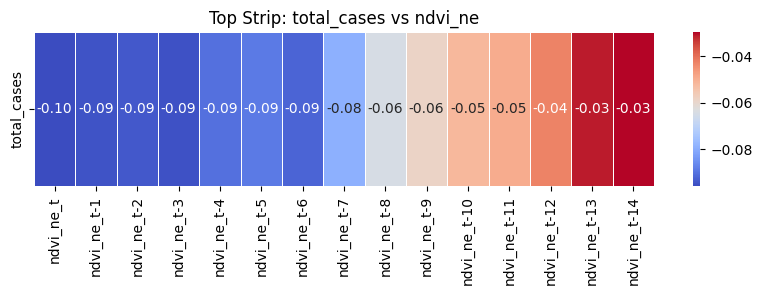

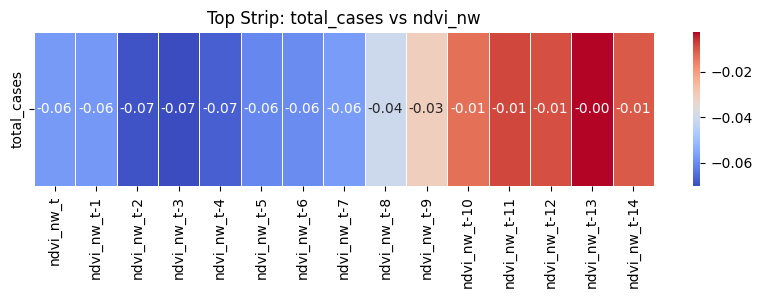

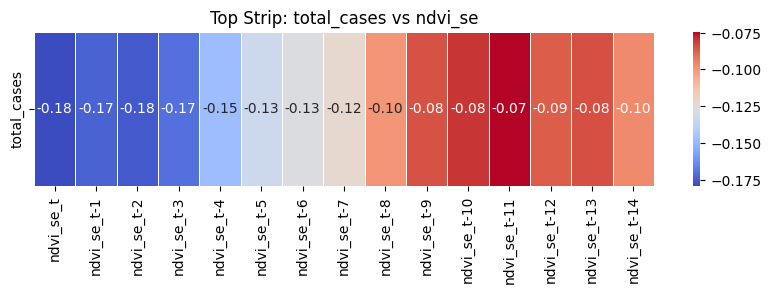

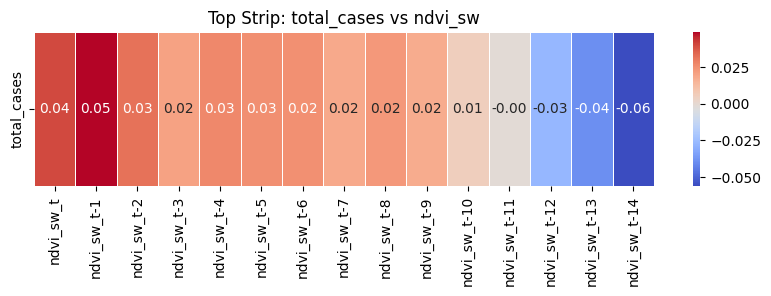

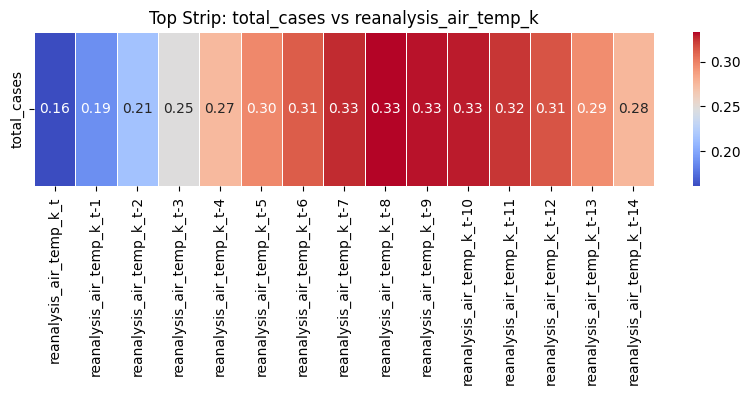

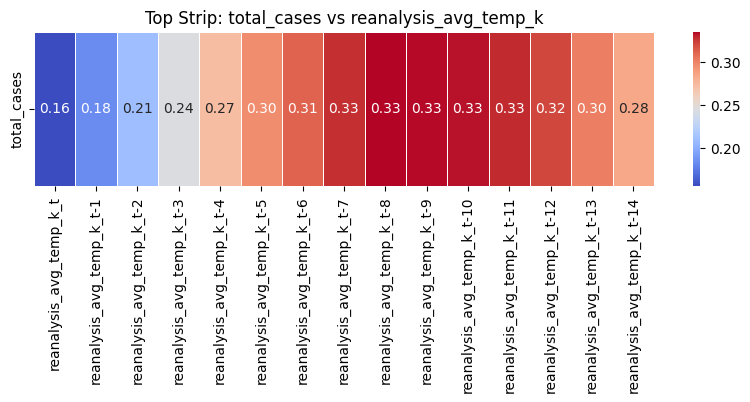

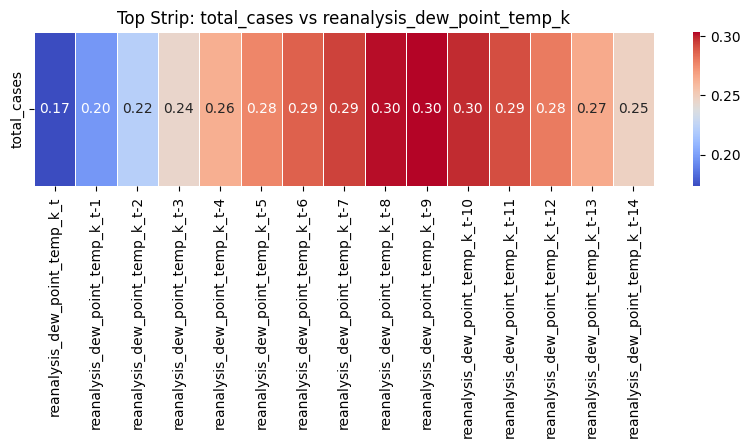

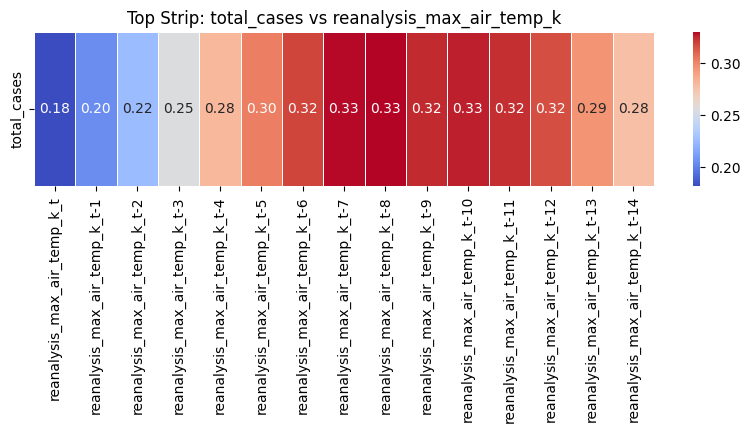

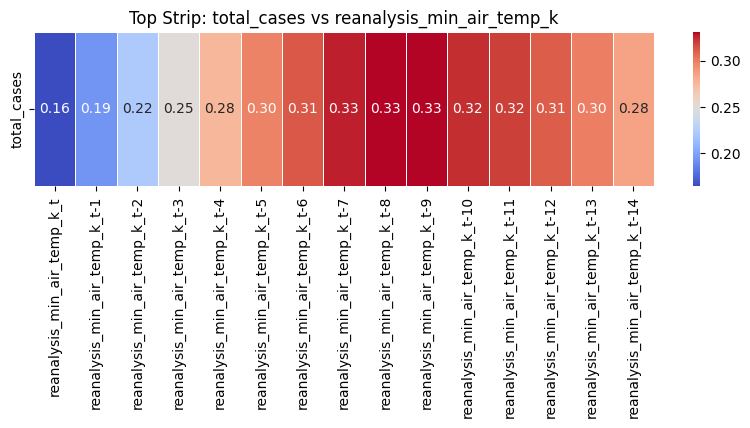

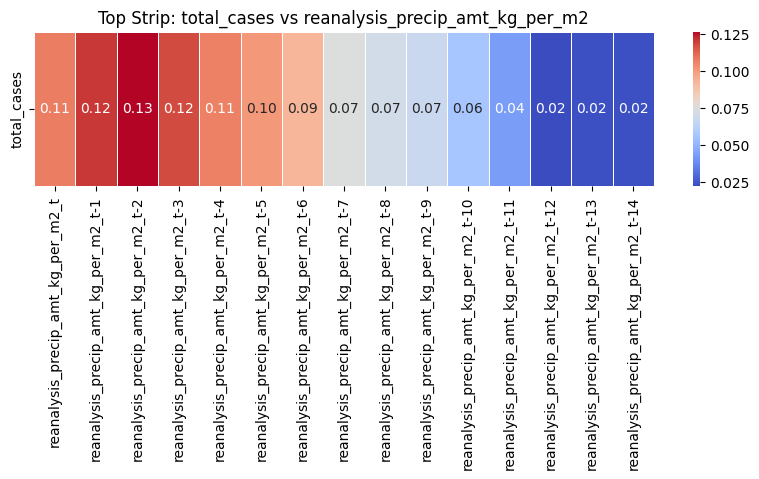

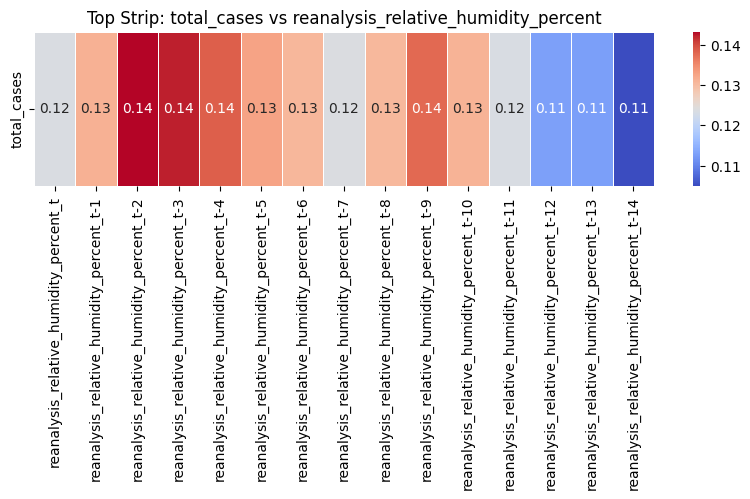

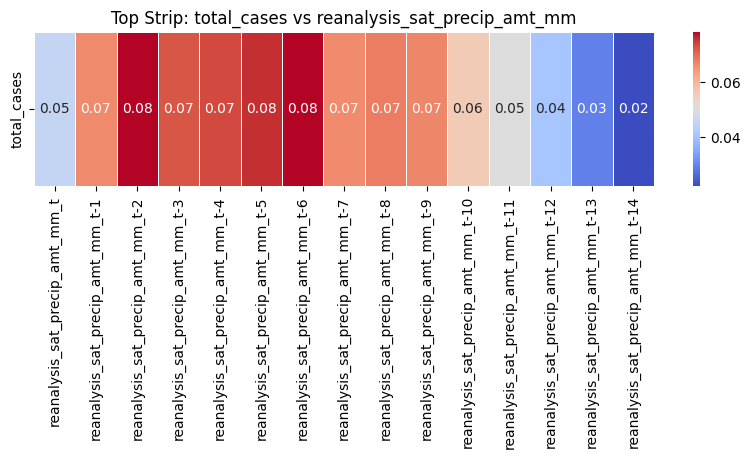

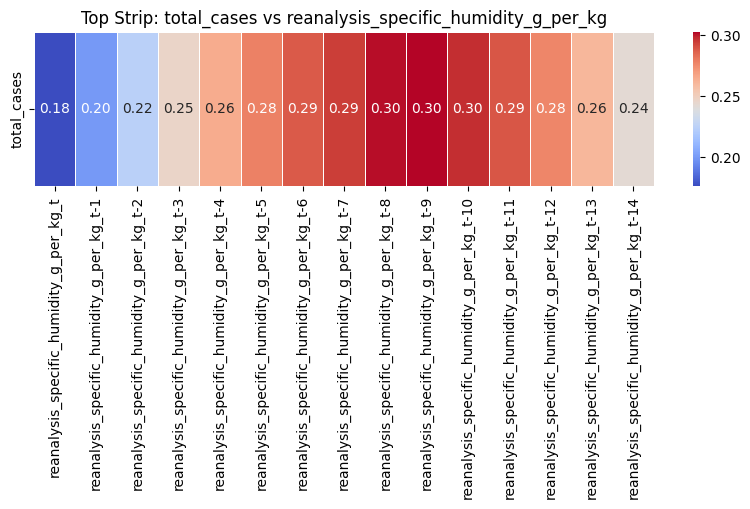

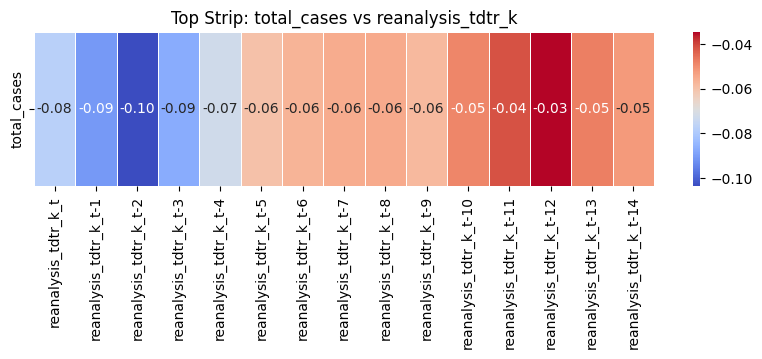

Optimal Lag Values:
{'ndvi_ne': 'ndvi_ne_t', 'ndvi_nw': 'ndvi_nw_t-3', 'ndvi_se': 'ndvi_se_t', 'ndvi_sw': 'ndvi_sw_t-14', 'reanalysis_air_temp_k': 'reanalysis_air_temp_k_t-8', 'reanalysis_avg_temp_k': 'reanalysis_avg_temp_k_t-8', 'reanalysis_dew_point_temp_k': 'reanalysis_dew_point_temp_k_t-9', 'reanalysis_max_air_temp_k': 'reanalysis_max_air_temp_k_t-8', 'reanalysis_min_air_temp_k': 'reanalysis_min_air_temp_k_t-8', 'reanalysis_precip_amt_kg_per_m2': 'reanalysis_precip_amt_kg_per_m2_t-2', 'reanalysis_relative_humidity_percent': 'reanalysis_relative_humidity_percent_t-2', 'reanalysis_sat_precip_amt_mm': 'reanalysis_sat_precip_amt_mm_t-6', 'reanalysis_specific_humidity_g_per_kg': 'reanalysis_specific_humidity_g_per_kg_t-9', 'reanalysis_tdtr_k': 'reanalysis_tdtr_k_t-2'}


In [133]:
# Set the maximum number of displayed columns to None (unlimited) for clarity
pd.set_option('display.max_columns', None)

# Define the target variable
target_variable = 'total_cases'

# Create an empty dictionary to store optimal lag values for each feature
optimal_lags = {}

# Loop through each feature and calculate the correlation matrix
for feature in features:
    feature_columns = sj_df_train_lagged.filter(regex=f'^{feature}_t(-\d+)?$')
    target_feature_matrix = sj_df_train[[target_variable]].join(feature_columns)
    correlation_matrix = target_feature_matrix.corr()

    # Extract the top strip of the correlation matrix
    top_strip = correlation_matrix.iloc[0, 1:]

    # Find the lag value with the highest absolute correlation
    optimal_lag = top_strip.abs().idxmax()

    # Store the optimal lag value in the dictionary
    optimal_lags[feature] = optimal_lag

    # Plot only the top strip of the correlation matrix
    plt.figure(figsize=(10, 2))
    sns.heatmap(top_strip.to_frame().T, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f'Top Strip: {target_variable} vs {feature}')
    plt.show()

# Display the dictionary of optimal lag values
print("Optimal Lag Values:")
print(optimal_lags)


The list produced directly above gives the optimal lag values between each target to lagged feature.  These will be used for modelling inputs.  The list can be checked against the partial heatmaps provided above.  The selections make sense.  

The below should generate crosscorrelation plots for the target-to-lagged-feature pairings.

In [ ]:
# Specify the maximum lag you want to consider
max_lag = 10

# Calculate cross-correlation and plot
for column in df.columns:
    crosscorr_values = crosscorr(df['your_target_column'], df[column], max_lag)
    
    plt.figure(figsize=(10, 5))
    plt.stem(range(-max_lag, max_lag + 1), crosscorr_values, use_line_collection=True)
    plt.title(f'Cross-Correlation between {column} and your_target_column')
    plt.xlabel('Lag')
    plt.ylabel('Cross-Correlation')
    plt.show()